In [1]:
# -------------------------------------------------------------------------------
# Name: main.py
# Purpose: Pull data from twitter, perform sentiment analysis and pull stock data
#
# Author(s):    David Little
#
# Created:      04/26/2021
# Updated:
# Update Comment(s):
#
# TO DO:
#
# -------------------------------------------------------------------------------


import requests
import pandas as pd
import time
import regex as re
from datetime import datetime, timedelta

In [3]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'retweet_count': tweet['public_metrics']['retweet_count'],
        'like_count': tweet['public_metrics']['like_count'],
        'reply_count': tweet['public_metrics']['reply_count']
#        'quote_count': tweet['public_metrics']['quote_count']
    }
    return data

In [4]:
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
tesla = re.compile(r"(?i)@Tesla(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

In [5]:
#------------------------------------- Twitter Pull  --------------------------------------------------------

# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'  # 'https://api.twitter.com/2/tweets/search/all'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(tesla OR tsla OR elon musk) (lang:en) -is:retweet',
    'max_results': '100',
    'tweet.fields': 'created_at,lang,public_metrics'
        }

In [6]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)

In [7]:
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=6)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API
now

'2021-08-12T14:56:57Z'

In [8]:
df = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 6 days ago, break the loop
        break
    pre60 = time_travel(now, 30)  # get x minutes before 'now'
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request
    time.sleep(1)
    now = pre60  # move the window 60 minutes earlier
    # iteratively append our tweet data to our dataframe
    for tweet in response.json()['data']:
        row = get_data(tweet)  # we defined this function earlier
        if row['like_count']>=1 and row['retweet_count']>=1 and row['reply_count']>=0:   #row['like_count'] >=3:
            df = df.append(row, ignore_index=True)
df

,created_at,id,like_count,reply_count,retweet_count,text
0,2021-08-12T14:56:21.000Z,1425833541871443972,10.0,1.0,2.0,Baby Doge Coin is all grown up and giving away...
1,2021-08-12T14:56:04.000Z,1425833469460897807,1.0,0.0,1.0,Elon Musk Shares His 5-Step Process in Candid ...
2,2021-08-12T14:55:36.000Z,1425833350946725890,101.0,0.0,6.0,Another vid sold! Riding him hard in self driv...
3,2021-08-12T14:54:41.000Z,1425833120440283148,1.0,0.0,1.0,$TESLA Increase Charging Stations in TEXAS htt...
4,2021-08-12T14:54:06.000Z,1425832975028166656,2.0,0.0,1.0,East Hartford's PZC voted unanimously to appro...
...,...,...,...,...,...,...
2998,2021-08-06T15:25:06.000Z,1423666448749273094,93.0,13.0,5.0,"Tesla doesn’t want to play the game, it should..."
2999,2021-08-06T15:24:25.000Z,1423666277697167361,10.0,1.0,2.0,The irony of Tesla driving innovation but not ...
3000,2021-08-06T15:24:08.000Z,1423666203525005319,8.0,0.0,1.0,Elon Musk replied to @jrosinski97 #SpaceX #Sta...
3001,2021-08-06T15:23:59.000Z,1423666165994463235,1.0,0.0,1.0,$KXIN STRAIGHT UP! $NIO DEAL BACK TO $11.00🚀 $...


In [9]:
#---------------------------------------------- Sentiment Model ------------------------------------------------------

import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

# we will append probability and sentiment preds later
probs = []
sentiments = []
clean_tweets = []
timestamp = []
binary = []

for time in df['created_at']:
    timestamp.append(((datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ')
                      - timedelta(hours = 4)) #timezone
                      - timedelta(hours = 0) #delay
                     ).strftime('%Y-%m-%d'))  # %H:00:00'))

for tweet in df['text']:
# we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = tesla.sub('Tesla', tweet)
    tweet = user.sub('', tweet)
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    if sentence.labels[0].value == 'NEGATIVE':
        probs.append(-1 * sentence.labels[0].score)  # numerical score 0-1
        binary.append(0)
    else:
        probs.append(sentence.labels[0].score)  # numerical score 0-1
        binary.append(1)
    clean_tweets.append(tweet)
    # print(tweet)
    # print(' ')

# add probability and sentiment predictions to tweets dataframe
df['text_clean'] = clean_tweets
df['probability'] = probs
df['sentiment'] = sentiments
df['binary'] = binary
df['Date'] = timestamp
#df['Date'] = pd.to_datetime(df['Date'])
df

2021-08-12 15:03:39,602 loading file C:\Users\djlittle\.flair\models\sentiment-en-mix-distillbert_4.pt


,created_at,id,like_count,reply_count,retweet_count,text,text_clean,probability,sentiment,binary,Date
0,2021-08-12T14:56:21.000Z,1425833541871443972,10.0,1.0,2.0,Baby Doge Coin is all grown up and giving away...,Baby Doge Coin is all grown up and giving away...,-0.994451,NEGATIVE,0,2021-08-12
1,2021-08-12T14:56:04.000Z,1425833469460897807,1.0,0.0,1.0,Elon Musk Shares His 5-Step Process in Candid ...,Elon Musk Shares His 5-Step Process in Candid ...,0.999360,POSITIVE,1,2021-08-12
2,2021-08-12T14:55:36.000Z,1425833350946725890,101.0,0.0,6.0,Another vid sold! Riding him hard in self driv...,Another vid sold! Riding him hard in self driv...,0.950297,POSITIVE,1,2021-08-12
3,2021-08-12T14:54:41.000Z,1425833120440283148,1.0,0.0,1.0,$TESLA Increase Charging Stations in TEXAS htt...,$TESLA Increase Charging Stations in TEXAS,0.567238,POSITIVE,1,2021-08-12
4,2021-08-12T14:54:06.000Z,1425832975028166656,2.0,0.0,1.0,East Hartford's PZC voted unanimously to appro...,East Hartford's PZC voted unanimously to appro...,0.953460,POSITIVE,1,2021-08-12
...,...,...,...,...,...,...,...,...,...,...,...
2998,2021-08-06T15:25:06.000Z,1423666448749273094,93.0,13.0,5.0,"Tesla doesn’t want to play the game, it should...","Tesla doesn’t want to play the game, it should...",-0.990225,NEGATIVE,0,2021-08-06
2999,2021-08-06T15:24:25.000Z,1423666277697167361,10.0,1.0,2.0,The irony of Tesla driving innovation but not ...,The irony of Tesla driving innovation but not ...,-0.999154,NEGATIVE,0,2021-08-06
3000,2021-08-06T15:24:08.000Z,1423666203525005319,8.0,0.0,1.0,Elon Musk replied to @jrosinski97 #SpaceX #Sta...,Elon Musk replied to #SpaceX #Starship #Mars,-0.974884,NEGATIVE,0,2021-08-06
3001,2021-08-06T15:23:59.000Z,1423666165994463235,1.0,0.0,1.0,$KXIN STRAIGHT UP! $NIO DEAL BACK TO $11.00🚀 $...,$KXIN STRAIGHT UP! $NIO DEAL BACK TO $11.00🚀 $...,-0.998563,NEGATIVE,0,2021-08-06


In [10]:
#________________________________ Stock Data __________________________________________________________________

import yfinance as yf

tsla = yf.Ticker("TSLA")
tsla_stock = tsla.history(
    start=datetime.strptime(df['created_at'].min(),'%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d'),
    end=(datetime.strptime(df['created_at'].max(),'%Y-%m-%dT%H:%M:%S.%fZ')+timedelta(days = 2)).strftime('%Y-%m-%d'),
    interval='1d'   #'60m'
        ).reset_index()
tsla_stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-06,711.900024,716.330017,697.630005,699.099976,15576200,0,0
1,2021-08-09,710.169983,719.030029,705.130005,713.760010,14715300,0,0
2,2021-08-10,713.989990,716.590027,701.880005,709.989990,13253000,0,0
3,2021-08-11,712.710022,715.179993,704.210022,707.820007,9739200,0,0
4,2021-08-12,706.340027,722.750000,699.400024,722.250000,17216950,0,0


In [11]:
converted = []
for time in tsla_stock['Date']:
    converted.append(time.strftime('%Y-%m-%d'))  # %H:00:00'))
tsla_stock['Date'] = converted
#tsla_stock['Date'] = pd.to_datetime(tsla_stock['Date'])
tsla_stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-06,711.900024,716.330017,697.630005,699.099976,15576200,0,0
1,2021-08-09,710.169983,719.030029,705.130005,713.760010,14715300,0,0
2,2021-08-10,713.989990,716.590027,701.880005,709.989990,13253000,0,0
3,2021-08-11,712.710022,715.179993,704.210022,707.820007,9739200,0,0
4,2021-08-12,706.340027,722.750000,699.400024,722.250000,17216950,0,0


In [12]:
means = df.groupby(['Date'],  as_index=False).mean()
means

,Date,like_count,reply_count,retweet_count,probability,binary
0,2021-08-06,41.409091,3.413636,5.872727,-0.124985,0.431818
1,2021-08-07,50.131183,4.141935,8.062366,0.068130,0.533333
2,2021-08-08,92.778271,9.638581,18.152993,-0.067538,0.470067
3,2021-08-09,49.502655,3.840708,7.913274,0.039115,0.523894
4,2021-08-10,49.893864,3.568823,8.731343,-0.114142,0.441128
5,2021-08-11,62.371002,4.362473,14.918977,-0.072726,0.464819
6,2021-08-12,120.352174,7.991304,9.182609,-0.064444,0.469565


In [13]:
means['Date']

0    2021-08-06
1    2021-08-07
2    2021-08-08
3    2021-08-09
4    2021-08-10
5    2021-08-11
6    2021-08-12
Name: Date, dtype: object

In [14]:
tsla_stock['Date']

0    2021-08-06
1    2021-08-09
2    2021-08-10
3    2021-08-11
4    2021-08-12
Name: Date, dtype: object

In [15]:
combined = means.merge(tsla_stock, how='inner')
combined

,Date,like_count,reply_count,retweet_count,probability,binary,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-06,41.409091,3.413636,5.872727,-0.124985,0.431818,711.900024,716.330017,697.630005,699.099976,15576200,0,0
1,2021-08-09,49.502655,3.840708,7.913274,0.039115,0.523894,710.169983,719.030029,705.130005,713.760010,14715300,0,0
2,2021-08-10,49.893864,3.568823,8.731343,-0.114142,0.441128,713.989990,716.590027,701.880005,709.989990,13253000,0,0
3,2021-08-11,62.371002,4.362473,14.918977,-0.072726,0.464819,712.710022,715.179993,704.210022,707.820007,9739200,0,0
4,2021-08-12,120.352174,7.991304,9.182609,-0.064444,0.469565,706.340027,722.750000,699.400024,722.250000,17216950,0,0


In [16]:
#combined['like_count'].corr(combined['Close'])
combined['binary'].corr(combined['Close'])

0.5239046487325524

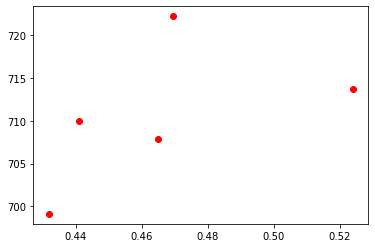

In [17]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# plot the data
ax.plot(combined['binary'],combined['Close'], 'ro')

In [18]:
#import tweepy

#auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
#auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

#api = tweepy.API(auth)

#public_tweets = api.home_timeline()
#for tweet in public_tweets:
#    print(tweet.text)